# Allenare un modello CNN con pytorch

CNN: Convolutional Neural Network


1. scegliere e scaricare il modello: EfficientDet
2. costruire il dataset e il dataloader
3. costruire la funzione di training

In [ ]:
!pip install albumentations==0.4.6
!pip install effdet

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Scegliere il modello CNN

EfficientDet: https://arxiv.org/pdf/1911.09070

Libreria Python: https://github.com/rwightman/efficientdet-pytorch/tree/master

REMEMBER:
1. Image-size in input
2. Numero di classi che il modello deve avere in output

In [3]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_train_efficientdet(
    architecture: str,
    image_size: float,
    backbone_architecture: str|None=None,
    num_classes: int=1,
    ):
    """
    creates train model
    input: architecture: what kind of effdet model?
           backbone_architecture: what kind of backbone?
    """
    config = get_efficientdet_config(architecture)
    if backbone_architecture is not None:
      config.update({'backbone_name': backbone_architecture})
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    train_model=DetBenchTrain(net, config)
    return train_model

In [ ]:
model = get_train_efficientdet(
    architecture='tf_efficientdet_d7x',
    backbone_architecture='tf_efficientnetv2_l',
    image_size=512,
    num_classes=1
    )

Usare il modello as-is

In [9]:
from PIL import Image
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
img = Image.open(
    '/content/drive/MyDrive/Colab Notebooks/cnn-models-data/images/15-05-2022_10-00-00.png'
    )

In [13]:
def get_test_transforms(img_size: float):
    return albumentations.Compose([
            albumentations.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

image_size=model.config['image_size']
transform=get_test_transforms(image_size[0])
image = np.array(img)
image = image / 255.0
image = image.astype(np.float64)
sample = {
    'image': image,
    'img_size': image_size,
    'img_scale': 1.0
}
sample=transform(**sample)
image=sample['image']
img_info={}
img_info['img_size']= sample['img_size']
img_info['img_scale']= sample['img_scale']

In [17]:
from effdet import DetBenchPredict
from PIL import ImageDraw
import torchvision.transforms.functional as FT

net = EfficientDet(model.config, pretrained_backbone=True)
net.class_net = HeadNet(model.config, num_outputs=model.config.num_classes)
net = DetBenchPredict(net)
net=net.to(device)

output=net(torch.stack([image]).float().to(device))
draw = ImageDraw.Draw(img)
for i,box in enumerate(output[0][:, :-2].tolist()):
  draw.rectangle([box[0], box[1], box[0]+box[2], box[1]+box[2]], outline='red', width=3)

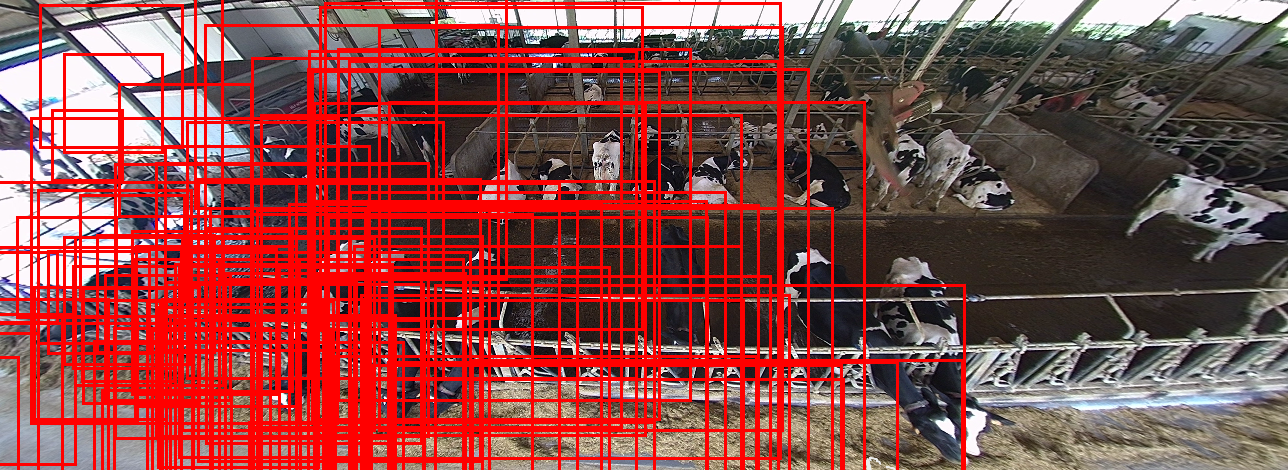

In [19]:
img

## Costruire dataset e dataloader

1. capire il formato dei dati a disposizione: COCO vs PASCAL-VOC
2. capire il formato dei dati che vuole il modello: COCO vs PASCAL-VOC
2. scegliere come suddividere i dati (train, test, validation)
3. scegliere il batch di caricamento dati
4. scegliere le funzioni di augmentation da usare

REMEMBER:

le funzioni di augmentation possono cambiare fra dati di train e dati di test


Formato COCO:
```
{
  "info": {
    "description": "Esempio di dataset COCO per il training",
    "version": "1.0",
    "year": 2025,
    "contributor": "PBG",
    "date_created": "2025-01-27"
  },
  "licenses": [...],
  "images": [
    {
      "id": 1,
      "file_name": "immagine1.jpg",
      "width": 640,
      "height": 480
    },
    {
      "id": 2,
      "file_name": "immagine2.jpg",
      "width": 800,
      "height": 600
    }
  ],
  "annotations": [
    {
      "id": 1,
      "image_id": 1,
      "category_id": 1,
      "bbox": [100, 150, 200, 300],
      "area": 60000,
      "iscrowd": 0
    },
    {
      "id": 2,
      "image_id": 1,
      "category_id": 2,
      "bbox": [50, 50, 100, 200],
      "area": 20000,
      "iscrowd": 0
    }
  ],
  "categories": [
    {
      "id": 1,
      "name": "cow"
    },
    {
      "id": 2,
      "name": "person"
    }
  ]
}
```


Formato Pascal-Voc: file XML (uno per immagine)
```
<annotation>
    <folder>dataset</folder>
    <filename>immagine1.jpg</filename>
    <path>/percorso/alla/cartella/immagine1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>640</width>
        <height>480</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cow</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>150</ymin>
            <xmax>300</xmax>
            <ymax>450</ymax>
        </bndbox>
    </object>
    <object>
        <name>person</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>50</xmin>
            <ymin>50</ymin>
            <xmax>150</xmax>
            <ymax>250</ymax>
        </bndbox>
    </object>
</annotation>

```

In [20]:
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import random
import torchvision.transforms.functional as FT

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    Input: set_1= set 1, a tensor of dimensions (n1, 4)
           set_2= set 2, a tensor of dimensions (n2, 4)
    Output: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]

def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    Input: set_1= set 1, a tensor of dimensions (n1, 4)
           set_2= set 2, a tensor of dimensions (n2, 4)
    Output: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    # Find the union
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection

    return intersection / union
def random_crop(image, boxes, labels):
    """
    Performs a random crop. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Input: image= image, a tensor of dimensions (3, original_h, original_w)
           boxes= bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
           labels= labels of objects, a tensor of dimensions (n_objects)
        :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.shape[0]
    original_w = image.shape[1]
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])
        if min_overlap is None:
            return image, boxes, labels
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0), boxes)
            overlap = overlap.squeeze(0)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[top:bottom, left:right, :]  # (3, new_h, new_w)
            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)
            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index
            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue
            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels
def image_crop_left(image, boxes=None, labels=None):
    """
    the original image is too unbalanced with respect to width and hight dimensions,
    hence we crop the image in two parts and then we will rebuild the original image
    inputs: image= the original image as tensor
            boxes= None means we are in test setting
            labels= None means we are in test setting
    """
    if boxes is None and labels is None: # if no need to check boxes
      image=FT.to_tensor(image)
      original_h = image.size(1)
      original_w = image.size(2)
      left = int(np.ceil(original_w-original_w*3/5))
      image=image[:, :, left:]
      new_image=FT.to_pil_image(image)
      return new_image
    else:
      original_h = image.shape[0]
      original_w = image.shape[1]
      left = int(np.ceil(original_w-original_w*3/5))
      crop = torch.FloatTensor([left, 0, original_w, original_h])  # (4)
      new_image = image[:, left:, :]
      bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)
      centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < original_w) * (bb_centers[:, 1] > 0) * (bb_centers[:, 1] < original_h)
      # Discard bounding boxes that don't meet this criterion
      new_boxes = boxes[centers_in_crop, :]
      new_labels = labels[centers_in_crop]

      # Calculate bounding boxes' new coordinates in the crop
      new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
      new_boxes[:, :2] -= crop[:2]
      new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
      new_boxes[:, 2:] -= crop[:2]

      return new_image, new_boxes, new_labels


def image_crop_right(image, boxes=None, labels=None):
    """
    the original image is too unbalanced with respect to width and hight dimensions,
    hence we crop the image in two parts and then we will rebuild the original image
    inputs: image= the original image as tensor
            boxes= None means we are in test setting
            labels= None means we are in test setting
    """

    if boxes is None and labels is None:
      image=FT.to_tensor(image)
      original_h = image.size(1)
      original_w = image.size(2)
      right = int(np.ceil(original_w*3/5)) -1
      image=image[:, :, :right]
      new_image=FT.to_pil_image(image)
      return new_image

    else:
      original_h = image.shape[0]
      original_w = image.shape[1]
      right = int(np.ceil(original_w*3/5)) -1
      crop = torch.FloatTensor([0, 0, right, original_h])
      new_image = image[:, :right, :]
      bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.
      centers_in_crop = (bb_centers[:, 0] > 0) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > 0) * (bb_centers[:, 1] < original_h)
      new_boxes = boxes[centers_in_crop, :]
      new_labels = labels[centers_in_crop]

      new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])
      new_boxes[:, :2] -= crop[:2]
      new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])
      new_boxes[:, 2:] -= crop[:2]
      return new_image, new_boxes, new_labels



def get_train_transforms(img_size, augmentation=False):
    """
    a series of transformations to apply for training data
    input: img_size= for resize()
           augmentation= True: we perform also transformations for data augmemntation
           augmentation= False: we perform only resizing and to_tensor transformation
    """
    if augmentation:
      return albumentations.Compose([
              albumentations.OneOf([
                  albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2,
                                      val_shift_limit=0.2, p=0.9),
                  albumentations.RandomBrightnessContrast(brightness_limit=0.2,
                                            contrast_limit=0.2, p=0.9),
              ],p=0.9),
              albumentations.ToGray(p=0.01),
              albumentations.HorizontalFlip(p=0.5),
              albumentations.Resize(height=img_size, width=img_size, p=1),
              ToTensorV2(p=1.0),
              ],
              p=1.0,
              bbox_params=albumentations.BboxParams(
                  format='pascal_voc',
                  min_area=0,
                  min_visibility=0,
                  label_fields=['labels']
              )
      )
    else:
      return albumentations.Compose(
        [
            albumentations.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=albumentations.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms(img_size):
    return albumentations.Compose(
        [
            albumentations.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=albumentations.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )



def get_test_transforms(img_size):
    return albumentations.Compose([
            albumentations.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)


In [21]:
import json
import os
from PIL import Image

class MyDataset(torch.utils.data.Dataset):
    """
    Dataset class where we store images with gt boxes and labels
    """
    def __init__(self,
                 data_folder: str,
                 img_size: float,
                 mode: str = "train",
                 image_dir = "",
                 augmentation: bool=False,
                 start:int=0,
                 *args,
                 **kwargs
                 ):
      """
      data folder: where json files are
      img_size: we need to pass it to transforms()
      image_dir where images are
      start: we need start to give a unique number to each instance
      """

      super().__init__(*args, **kwargs)

      self.split = mode.upper()
      with open(os.path.join(data_folder, 'images.json'), 'r') as fp:
          self.image_ids = json.load(fp)
      with open(os.path.join(data_folder, 'objects.json'), 'r') as fp:
          self.objects = json.load(fp)

      if len(self.image_ids) != len(self.objects):
        raise ValueError(
            "Images and Objects json must have same length"
        )
      self.data_folder=data_folder
      self.image_dir = image_dir
      self.mode = mode
      self.start=start
      self.augmentation=augmentation
      self.img_size=img_size

    def __getitem__(self, index: int):
        #each item in the dataset is a tuple of two elements:
        #the image as tensor and a dictionary containing all the informations we need as gtboxes, labels, etc etc

        image_id = self.image_ids[index]
        image = Image.open(os.path.join(self.data_folder, self.image_dir,image_id), mode='r').convert("RGB")
        # Convert to Numpy array
        image = np.array(image)
        image = image / 255.0
        image = image.astype(np.float32)

        if self.mode != "test":
            objects = self.objects[index]
            boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
            labels = torch.LongTensor(objects['labels'])  # (n_objects)

            area = [(box[2]-box[0])*(box[3]-box[1]) for box in boxes]
            area = torch.as_tensor(area, dtype=torch.float32)
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([self.start+index])
            target['area'] = area #area is computed before the transformation, this could be a problem!
            # These are needed as well by the efficientdet model.
            target['img_size'] = torch.tensor([(self.img_size, self.img_size)])
            target['img_scale'] = torch.tensor([1.])

        else:
            # test dataset must have some values so that transforms work.
            target = {'cls': torch.as_tensor([[0]], dtype=torch.float32),
                      'bbox': torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32),
                      'img_size': torch.tensor([(self.img_size, self.img_size)]),
                      'img_scale': torch.tensor([1.])}

        #now consider transformations:
        if self.mode == "train":
                image, target['boxes'], target['labels'] = image_crop_right(image,target['boxes'], target['labels'] )
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target['labels']
                }
                if len(sample['bboxes']) > 0:
                    if self.augmentation:
                      sample['image'], sample['bboxes'], sample['labels']= random_crop(sample['image'], sample['bboxes'], sample['labels'])

                    # Apply some augmentation on the fly.
                    transformations=get_train_transforms(self.img_size, augmentation=self.augmentation)
                    sample = transformations(**sample)
                    image = sample['image']
                    boxes = sample['bboxes']
                    temp = sample['labels']
                    target['labels']=torch.tensor([item.item() for item in temp])
                    # change to yxyx format for EfficientDet.
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)
                    target['boxes']= target['boxes'][:,(1,0,3,2)]
                    area = [(box[2]-box[0])*(box[3]-box[1]) for box in boxes]
                    area = torch.as_tensor(area, dtype=torch.float32)
                    target['area'] = area

        elif self.mode == "valid":
            image, target['boxes'], target['labels'] = image_crop_right(image,target['boxes'], target['labels'] )
            sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target['labels']
                }
            transformations=get_valid_transforms(self.img_size)
            sample = transformations(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            temp = sample['labels']
            target['labels']=torch.tensor([item.item() for item in temp])
            # change to yxyx format for EfficientDet.
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)
            target['boxes']= target['boxes'][:,(1,0,3,2)]
        else:
            sample = {
                'image': image,
                'bbox': target['bbox'],
                'cls': target['cls']
            }
            transformations=get_test_transforms(self.img_size)
            image = transformations(**sample)['image']

        return image, target #remember that target['boxes'] are in yxyx format
    def __len__(self) -> int:
        return len(self.image_ids)

In [48]:
dataset_no_aug = MyDataset('/content/drive/MyDrive/Colab Notebooks/cnn-models-data',512, 'train','images', augmentation=False, start=0)
dataset_aug = MyDataset('/content/drive/MyDrive/Colab Notebooks/cnn-models-data',512, 'train','images', augmentation=True, start=0)

dataset = torch.utils.data.ConcatDataset([dataset_no_aug, dataset_aug])

In [52]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=2, shuffle=True, pin_memory=True)

## Costruire la funzione di training

In [49]:
import time
from tqdm import tqdm

def train(train_loader, valid_loader, model, optimizer, scheduler, num_epochs):
    """
    training function:observe the model needs boxes inputs in yxyx format!
    """

    best_loss = float('inf')
    start_time = time.time()

    model.cuda()
    basemodel=model.model.to(device) #the 'real' effdet cnn
    anchors=model.anchors #to build anchors over feature maps
    loss_fn=model.loss_fn #to compute loss function

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        loop = tqdm(train_loader)
        running_loss = 0.0
        model.train()

        for i, data in enumerate(loop,0):
            images, targets = data
            #the following few lines are a pre-processing step:
            targets = [{k: v for k, v in t.items()} for t in targets]
            images = torch.stack(images).float().to(device)
            targets2 = {}
            targets2["bbox"] = [
                target["boxes"].float().to(device) for target in targets
            ]
            targets2["cls"] = [target["labels"].float().to(device) for target in targets]

            optimizer.zero_grad()
            # Forward prop.
            output = model(images, targets2)
            # Loss
            loss = output['loss']
            # Backward prop.
            loss.backward()
            #Update:
            optimizer.step()
            running_loss += loss.item()

            if i == len(train_loader)-1:
                    print('loss media sul minibatch training: %.3f' %(running_loss/len(train_loader)))
                    running_loss = 0.0

            loop.set_postfix(loss = loss.item())

            del output, images, targets2

        loop_valid = tqdm(valid_loader)
        running_loss_valid = 0.0
        model.eval()
        model_dict={}

        with torch.no_grad():
            for i, data in enumerate(loop_valid,0):
                images, targets = data
                #pre-processing step as for training:
                targets = [{k: v for k, v in t.items()} for t in targets]
                images = torch.stack(images).float().to(device)
                targets2 = {}
                targets2["bbox"] = [
                    target["boxes"].float().to(device) for target in targets
                ]
                targets2["cls"] = [target["labels"].float().to(device) for target in targets]
                targets2['img_scale']=torch.tensor([target["img_scale"].item() for target in targets]).to(device)
                targets2['img_size']=torch.tensor([model.config['image_size'] for target in targets]).to(device)
                targets2['img_id']= torch.tensor([target["image_id"].item() for target in targets]).to(device)

                # Forward prop.
                output = model(images, targets2)
                valid_loss = output['loss']
                # no backward and optimizer.step/zero_grad in validation
                # Update:
                running_loss_valid += valid_loss.item()

                # Print status
                if i == len(valid_loader)-1:
                            scheduler.step()
                            scheduler.get_last_lr()
                            print('loss media sul minibatch valid: %.6f' %(running_loss_valid/len(valid_loader)))

                            if(running_loss_valid/len(valid_loader))<=best_loss:
                                            best_loss = running_loss_valid/len(valid_loader)
                                            tempo=time.localtime()
                                            print('Best Model until now!')
                            running_loss_valid = 0.0
            loop_valid.set_postfix(loss = valid_loss.item())

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

In [ ]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), amsgrad=False)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50],gamma = 0.1,verbose = True, )

In [53]:
train(dataloader,dataloader, model, optimizer, scheduler, 5)

Epoch 0/4
----------


100%|██████████| 2/2 [00:02<00:00,  1.12s/it, loss=26.9]


loss media sul minibatch training: 28.906


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


loss media sul minibatch valid: 84.955013
Best Model until now!
Epoch 1/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=33.8]


loss media sul minibatch training: 29.190


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


loss media sul minibatch valid: 76.833504
Best Model until now!
Epoch 2/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.39it/s, loss=39.3]


loss media sul minibatch training: 31.704


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


loss media sul minibatch valid: 79.934685
Epoch 3/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.32it/s, loss=29.8]


loss media sul minibatch training: 26.756


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


loss media sul minibatch valid: 71.517307
Best Model until now!
Epoch 4/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.46it/s, loss=26.2]


loss media sul minibatch training: 25.019


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

loss media sul minibatch valid: 54.029451
Best Model until now!
Training complete in 0m 12s
Best val loss: 54.029451
